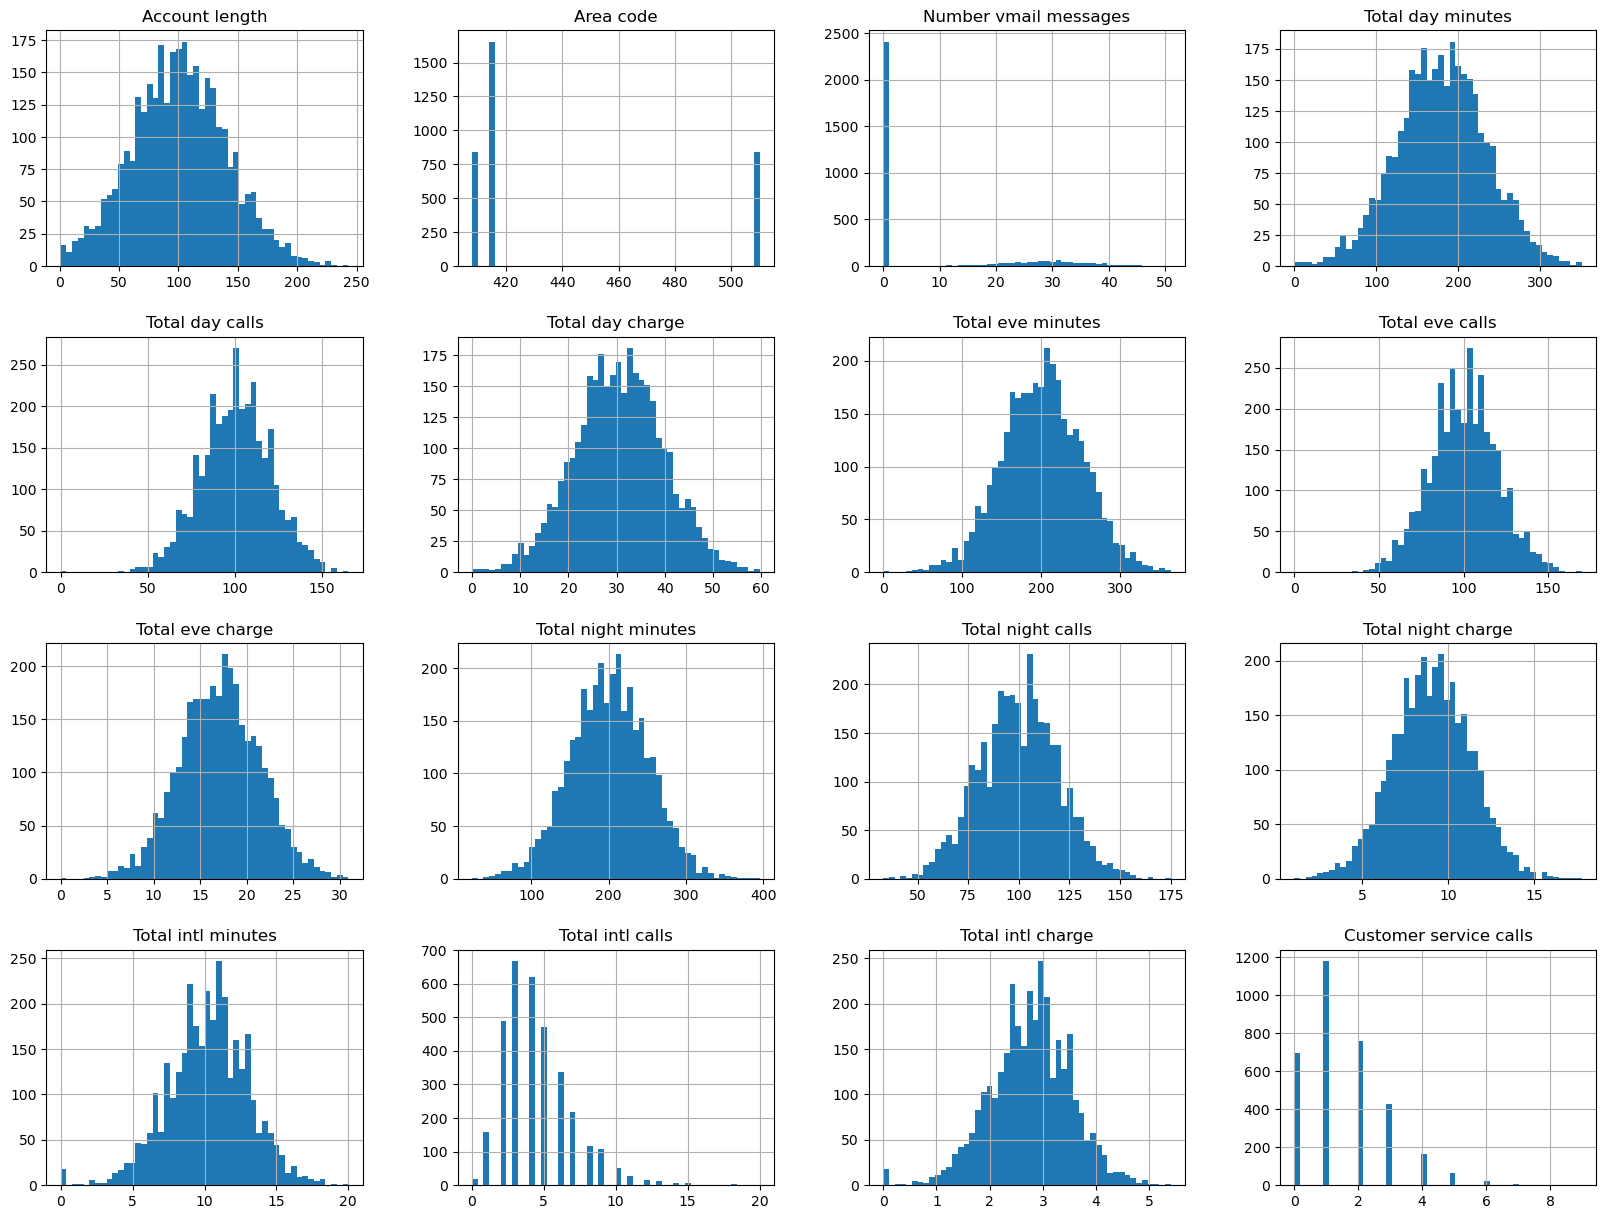

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read data from CSV files
data_20 = pd.read_csv('data/churn-bigml-20.csv')
data_80 = pd.read_csv('data/churn-bigml-80.csv')

# Combine the two datasets
data = pd.concat([data_20, data_80], ignore_index=True)

data.hist(bins=50, figsize=(20, 15))
plt.show()

Churn Rate:
Churn
False    0.855086
True     0.144914
Name: proportion, dtype: float64
Churn Correlation (sorted high to low):
Churn                     1.000000
International plan_Yes    0.259852
Customer service calls    0.208750
Total day minutes         0.205151
Total day charge          0.205151
Total eve minutes         0.092796
Total eve charge          0.092786
Total intl charge         0.068259
Total intl minutes        0.068239
State_NJ                  0.049111
State_TX                  0.044358
State_MD                  0.040752
Total night charge        0.035496
Total night minutes       0.035493
State_CA                  0.034547
State_SC                  0.034008
State_MI                  0.031570
State_MS                  0.028233
State_WA                  0.027136
State_NV                  0.027136
State_ME                  0.025329
State_MT                  0.024995
State_AR                  0.020270
Total day calls           0.018459
State_KS                  0.01697

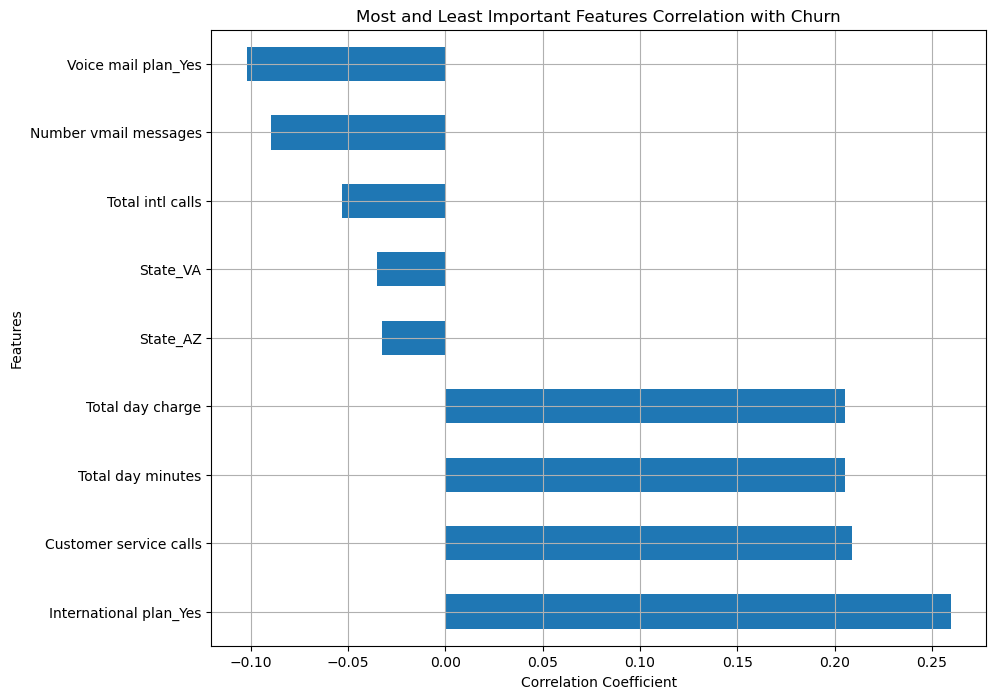

In [23]:
# Encode categorical variables
data_encoded = pd.get_dummies(data, drop_first=True)

# Churn rate
churn_rate = data_encoded['Churn'].value_counts(normalize=True)
print("Churn Rate:")
print(churn_rate)

# Correlation with churn
churn_corr = data_encoded.corr()['Churn'].sort_values(ascending=False)
pd.set_option('display.max_rows', None)  # Display all rows
print("Churn Correlation (sorted high to low):")
print(churn_corr)

# Number of features to display
n = 5

# Select the top n most and least important features
top_features = churn_corr.head(n).drop('Churn')
bottom_features = churn_corr.tail(n)

# Combine the two sets of features
important_features = pd.concat([top_features, bottom_features])

# Plot feature importance
plt.figure(figsize=(10, 8))
important_features.plot(kind='barh')
plt.title('Most and Least Important Features Correlation with Churn')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True)
plt.show()


In [29]:
# Read data
train_data = pd.read_csv('data/churn-bigml-80.csv')
test_data = pd.read_csv('data/churn-bigml-20.csv')

# Handle missing values by filling them with the mean of the numerical columns
numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
train_data[numerical_cols] = train_data[numerical_cols].fillna(train_data[numerical_cols].mean())
test_data[numerical_cols] = test_data[numerical_cols].fillna(test_data[numerical_cols].mean())

In [30]:
# Encode categorical variables using one-hot encoding
train_data_encoded = pd.get_dummies(train_data, drop_first=True)
test_data_encoded = pd.get_dummies(test_data, drop_first=True)

# Ensure both train and test sets have the same dummy variables
train_data_encoded, test_data_encoded = train_data_encoded.align(test_data_encoded, join='left', axis=1, fill_value=0)

# Initialize the scaler
scaler = StandardScaler()

In [32]:
# Apply scaling to the numerical features
numerical_features = train_data_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'Churn' in numerical_features:
    numerical_features.remove('Churn')  # Remove the target variable

train_data_encoded[numerical_features] = scaler.fit_transform(train_data_encoded[numerical_features])
test_data_encoded[numerical_features] = scaler.transform(test_data_encoded[numerical_features])

# Prepare data for training
important_features = [col for col in train_data_encoded.columns if col != 'Churn']
X_train = train_data_encoded[important_features]
y_train = train_data_encoded['Churn']
X_test = test_data_encoded[important_features]
y_test = test_data_encoded['Churn']

# Create Pool for CatBoost
from catboost import Pool

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

Logistic Regression Performance:
Accuracy: 0.85457
Precision: 0.47727
Recall: 0.22105
F1-Score: 0.30216
------------------------------
Random Forest Performance:
Accuracy: 0.94753
Precision: 0.98387
Recall: 0.64211
F1-Score: 0.77707
------------------------------
CatBoost Performance:
Accuracy: 0.95052
Precision: 0.89744
Recall: 0.73684
F1-Score: 0.80925
------------------------------


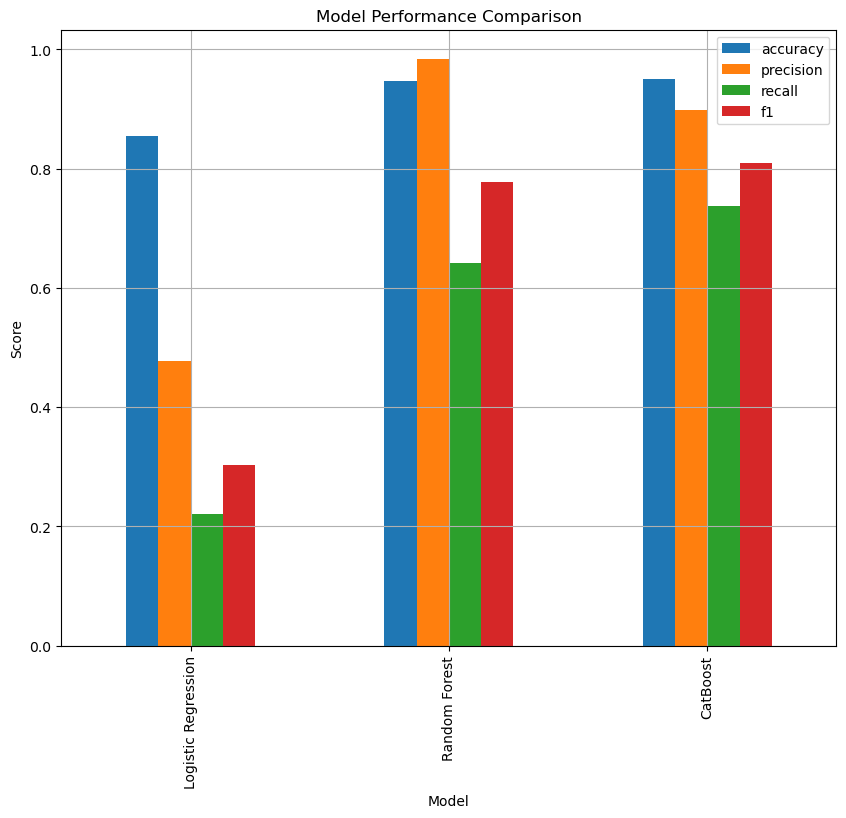

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize models
log_reg = LogisticRegression()
rand_forest = RandomForestClassifier(n_estimators=100, max_depth=None)
catboost = CatBoostClassifier(iterations=500, depth=12, learning_rate=0.1, verbose=0)

# Train models
log_reg.fit(X_train, y_train)
rand_forest.fit(X_train, y_train)
catboost.fit(X_train, y_train)

# Predict and evaluate models
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rand_forest,
    'CatBoost': catboost
}

# Store results for plotting
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Print results
for name, metrics in results.items():
    print(f'{name} Performance:')
    print(f'Accuracy: {metrics["accuracy"]:.5f}')
    print(f'Precision: {metrics["precision"]:.5f}')
    print(f'Recall: {metrics["recall"]:.5f}')
    print(f'F1-Score: {metrics["f1"]:.5f}')
    print('-'*30)

# Plot results
metrics_df = pd.DataFrame(results).T
metrics_df.plot(kind='bar', figsize=(10, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.grid(True)
plt.show()